In [100]:
    import hopsworks
    import pandas as pd
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn.ensemble import GradientBoostingClassifier
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib
    import os

In [38]:
import os
 
for k, v in os.environ.items():
    if "HOPS" in k:
        print(f'{k}={v}')

In [39]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/185498
Connected. Call `.close()` to terminate connection gracefully.


In [40]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine_quality", version=2)
query = wine_fg.select_all()

label_encoder = fs.get_transformation_function(name="label_encoder")
quality_brac_fn = fs.get_transformation_function(name="quality_brac")

transformation_functions = {
    "type": label_encoder,
    "quality":quality_brac_fn}


feature_view = fs.get_or_create_feature_view(name="wine_quality",
                                  version=2,
                                  description="Read from dataset",
                                  query=query, transformation_functions = transformation_functions)

feature_view.labels = ['quality']

In [53]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Finished: Reading data from Hopsworks, using ArrowFlight (1.59s) 
(4240, 12)
(1060, 12)
(4240, 1)
(1060, 1)


In [139]:
from sklearn.model_selection import GridSearchCV

model_params  = {
    "random_forest":{
        "model": RandomForestClassifier(),
        "params":{
            "n_estimators":[3,5,7,9],
            "max_depth":[5,6,9,10],
            "class_weight": ['balanced_subsample', 'balanced']
        }
    },
    'knn' : {
        'model' : KNeighborsClassifier(),
        'params': {
            "n_neighbors" : [3,5,10, 20, 50]
        }
    },
    'GradBoost' : {
        'model' : GradientBoostingClassifier(),
        'params': {
            "n_estimators":[50, 100, 200],
            "max_depth":[1,2,3,5]
        }
    }
}

In [140]:
score=[]
for model_name,mp in model_params.items():
    clf = GridSearchCV(mp["model"],mp["params"],cv=6,return_train_score=False)
    clf.fit(X_train,y_train.values.ravel())
    score.append({
        "Model" : model_name,
        "Best_Score": clf.best_score_,
        "Best_Params": clf.best_params_
    })

In [141]:
df_search_res = pd.DataFrame(score,columns=["Model","Best_Score","Best_Params"])
print(df_search_res)

           Model  Best_Score  \
0  random_forest    0.742217   
1            knn    0.760142   
2      GradBoost    0.787973   

                                         Best_Params  
0  {'class_weight': 'balanced_subsample', 'max_de...  
1                                {'n_neighbors': 50}  
2              {'max_depth': 5, 'n_estimators': 100}  


In [142]:
model = GradientBoostingClassifier(n_estimators=100, max_depth=5)
model.fit(X_train, y_train.values.ravel())

GradientBoostingClassifier(max_depth=5)

In [143]:
# Evaluate model performance using the features from the train set (X_train)
y_train_pred = model.predict(X_train)

# Compare predictions (y_train_pred) with the labels in the train set (y_tain)
metrics = classification_report(y_train, y_train_pred, output_dict=True)
results = confusion_matrix(y_train, y_train_pred)

print(metrics)
print(results)
print(results[2,:].sum()/results.sum())

{'Bad': {'precision': 1.0, 'recall': 0.7526881720430108, 'f1-score': 0.8588957055214724, 'support': 186}, 'Good': {'precision': 0.956390977443609, 'recall': 0.7784577723378213, 'f1-score': 0.8582995951417004, 'support': 817}, 'Ok': {'precision': 0.9339155749636099, 'recall': 0.9910410874266296, 'f1-score': 0.961630695443645, 'support': 3237}, 'accuracy': 0.939622641509434, 'macro avg': {'precision': 0.963435517469073, 'recall': 0.8407290106024873, 'f1-score': 0.8929419987022725, 'support': 4240}, 'weighted avg': {'precision': 0.9411453171529797, 'recall': 0.939622641509434, 'f1-score': 0.9372131914171797, 'support': 4240}}
[[ 140    0   46]
 [   0  636  181]
 [   0   29 3208]]
0.7634433962264151


In [144]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

print(metrics)
print(results)

{'Bad': {'precision': 0.4444444444444444, 'recall': 0.16326530612244897, 'f1-score': 0.23880597014925373, 'support': 49}, 'Good': {'precision': 0.5968992248062015, 'recall': 0.4052631578947368, 'f1-score': 0.48275862068965514, 'support': 190}, 'Ok': {'precision': 0.8313253012048193, 'recall': 0.9244823386114495, 'f1-score': 0.8754325259515571, 'support': 821}, 'accuracy': 0.7962264150943397, 'macro avg': {'precision': 0.6242229901518218, 'recall': 0.4976702675428784, 'f1-score': 0.5323323722634886, 'support': 1060}, 'weighted avg': {'precision': 0.7714214177170874, 'recall': 0.7962264150943397, 'f1-score': 0.7756186172401663, 'support': 1060}}
[[  8   0  41]
 [  0  77 113]
 [ 10  52 759]]


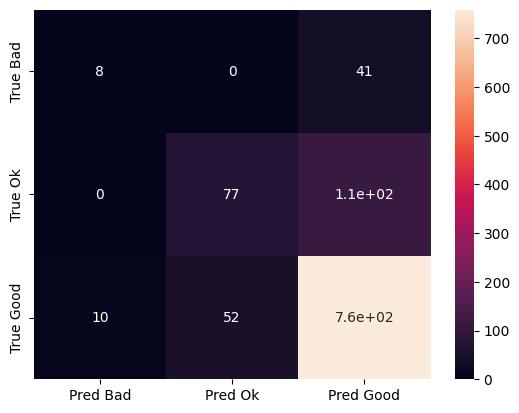

In [145]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['True Bad', 'True Ok', 'True Good'],
                     ['Pred Bad', 'Pred Ok', 'Pred Good'])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [146]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'wine_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Model export complete: 100%|██████████████████████| 6/6 [01:42<00:00, 17.16s/it]

Model created, explore it at https://c.app.hopsworks.ai:443/p/185498/models/wine_model/2


Model(name: 'wine_model', version: 2)